In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

pd.set_option('display.max_columns', 150)
pd.options.mode.chained_assignment = None  # default='warn'

In [81]:
path = 'data/'

In [111]:
# option 1: same features as in the paper
# data = pd.read_excel(path + 'Oncothromb_bbddMarzo2018.xlsx')
# X, y = get_data(data)

# option 2: more features
data = pd.read_csv(path + 'preprocessed_data_no_corr.csv')
X = data[data.columns.difference(['id','excluido','VTE'])]
y = data['VTE']

X.shape, y.shape

((369, 47), (369,))

In [112]:
X.head()

,Family,bmi,cateter,cirugiaPrev,diabetesM,dislip,edatDx,estadiGrup,fumador,hemoglobina,hta_desc,leucocits,plaquetes,psIniQT_desc,rs1039084,rs1063856,rs11696364,rs118203906,rs121909548,rs1613662,rs16861990,rs169713,rs1799963,rs1801020,rs1883888,rs2036914,rs2227589,rs2232698,rs268,rs3087505,rs4149755,rs4524,rs45454293,rs5985,rs6025,rs6034465,rs8176719,rs8176749,rs8176750,rs9332695,rs9363864,sexe,tipusTumor_colon,tipusTumor_esofago,tipusTumor_estomago,tipusTumor_pancreas,tipusTumor_pulmon
0,0,1,0,0,0,1,78,4,1,12.7,1,6800,169000,1,2,0,0,0,0,0,0,0,0,1,0,2,1,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,3,1,0,0,0,50,4,2,13.0,0,10900,203000,1,0,2,2,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,2,0,0,1,2,0,0,1,0,0,0
2,0,1,1,1,0,1,68,4,2,12.4,1,7700,194000,1,1,2,0,0,0,1,0,1,0,1,2,1,1,0,0,0,0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
3,0,1,1,0,1,1,71,4,2,10.4,1,8600,284000,1,1,2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,2,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0
4,0,2,1,0,0,0,59,4,1,12.3,1,8800,254000,1,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,2,1,0,0,0,2,0,0,0,0,0,1,0,0,0,0


In [113]:
y.value_counts()

0    298
1     71
Name: VTE, dtype: int64

In [114]:
# check outliers
# import seaborn as sns

# sns.boxplot(X['hemoglobina'])

In [115]:
from sklearn.model_selection import train_test_split

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1621)
print(X_train.shape, X_test.shape)

(276, 47) (93, 47)


In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [117]:
SEED = 1135
class_weight = {1:1}

base_models = [
          ('LR', LogisticRegression(solver='liblinear', max_iter=1000, random_state=SEED)), 
          ('RF', RandomForestClassifier(random_state=SEED, class_weight=class_weight)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(class_weight=class_weight)),
          ('SVM', SVC(probability=True, random_state=SEED, class_weight=class_weight)), 
          ('AB', AdaBoostClassifier(random_state=SEED)),
          ('GBM', GradientBoostingClassifier(random_state=SEED)),
          ('ET', ExtraTreesClassifier(random_state=SEED, class_weight=class_weight)),
          ('LGB', LGBMClassifier(class_weight=class_weight, random_state=SEED)),
#           ('XGB', XGBClassifier(random_state=SEED))
        ]

In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler_name = 'standard'
  
if scaler_name == 'standard':
    scaler = StandardScaler()
elif scaler_name =='minmax':
    scaler = MinMaxScaler()

pipelines = []
for name, model in base_models:
  pipelines.append((name  , Pipeline([('Scaler', scaler),(name,model)])))

In [119]:
final = run_exps(pipelines, X, y)
bootstrap_df, results = results_bootstrap(final)

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predic

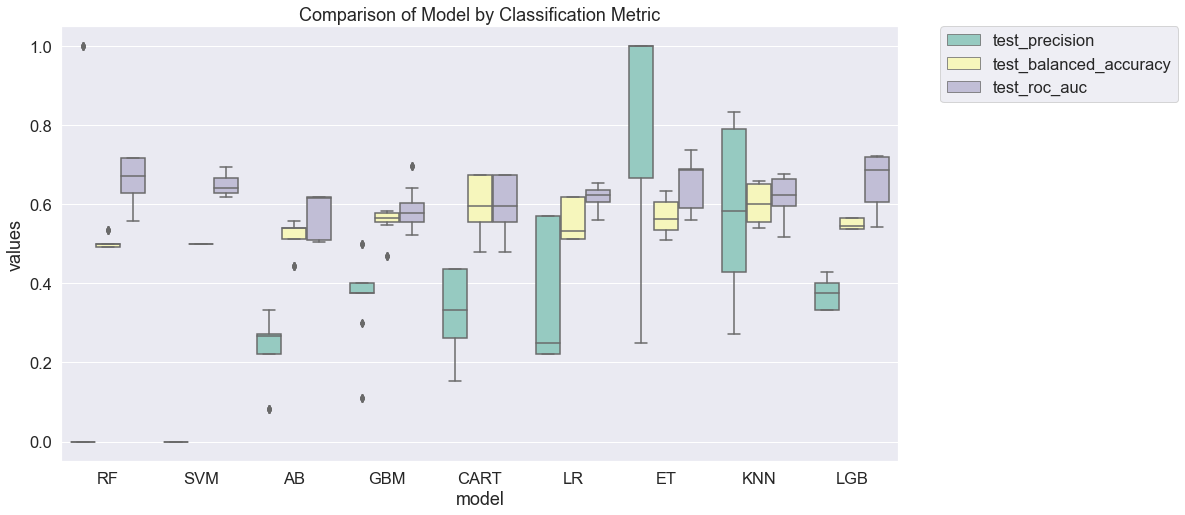

In [120]:
plot_performances(results)

In [121]:
tabulate_results(bootstrap_df, results)

test_balanced_accuracy           test_precision           test_roc_auc  \
                        mean       std           mean       std         mean   
model                                                                          
AB                  0.518665  0.042443       0.236556  0.089662     0.575350   
CART                0.582766  0.072244       0.303384  0.105753     0.582766   
ET                  0.575439  0.042187       0.808333  0.268979     0.660534   
GBM                 0.550982  0.037742       0.355778  0.120363     0.590934   
KNN                 0.600779  0.044962       0.585108  0.190410     0.614655   
LGB                 0.549620  0.013071       0.367071  0.036661     0.658516   
LR                  0.551889  0.043140       0.343333  0.148483     0.621661   
RF                  0.504810  0.016017       0.200000  0.404061     0.656531   
SVM                 0.500000  0.000000       0.000000  0.000000     0.650538   

                 
            std  
model            
AB     0.054793  
CART   0.072244  
ET     0.062936  
GBM    0.058220  
KNN    0.056598  
LGB    0.065479  
LR     0.029101  
RF     0.058386  
SVM    0.028155

In [122]:
clf = Pipeline([('Scaler', MinMaxScaler()),('LR',LogisticRegression())])
clf.fit(X_train, y_train)

Pipeline(steps=[('Scaler', MinMaxScaler()), ('LR', LogisticRegression())])

AUC score (train): 0.8245
AUC score (test): 0.7193


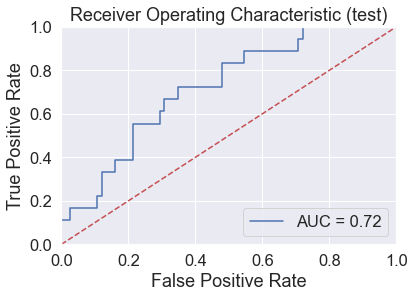


Accuracy in train set (%): 78.26
Accuracy in test set (%): 70.97

=====Train set=====
[[178  45]
 [ 15  38]]

Sensivity (%): 71.7
Specificity (%): 79.82000000000001
Precision (%): 45.78
NPV (%): 92.23

=====Test set=====
[[59 16]
 [11  7]]

Sensivity (%): 38.89
Specificity (%): 78.67
Precision (%): 30.43
NPV (%): 84.28999999999999


In [123]:
y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict_proba(X_test)[:,1]

evaluate_model(y_train, y_pred_train, y_test, y_pred_test)

AUC score (train): 0.9993
AUC score (test): 0.6911


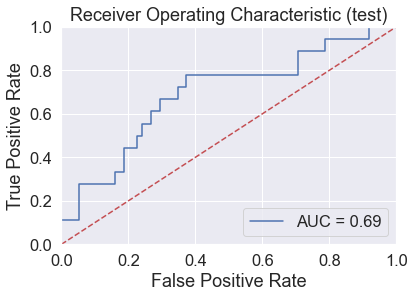


Accuracy in train set (%): 97.46
Accuracy in test set (%): 72.04

=====Train set=====
[[217   6]
 [  1  52]]

Sensivity (%): 98.11
Specificity (%): 97.31
Precision (%): 89.66
NPV (%): 99.53999999999999

=====Test set=====
[[61 14]
 [12  6]]

Sensivity (%): 33.33
Specificity (%): 81.33
Precision (%): 30.0
NPV (%): 83.56


In [124]:
clf = Pipeline([('Scaler', StandardScaler()),('SVM',SVC(probability=True))])
clf.fit(X_train, y_train)

y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict_proba(X_test)[:,1]

evaluate_model(y_train, y_pred_train, y_test, y_pred_test)

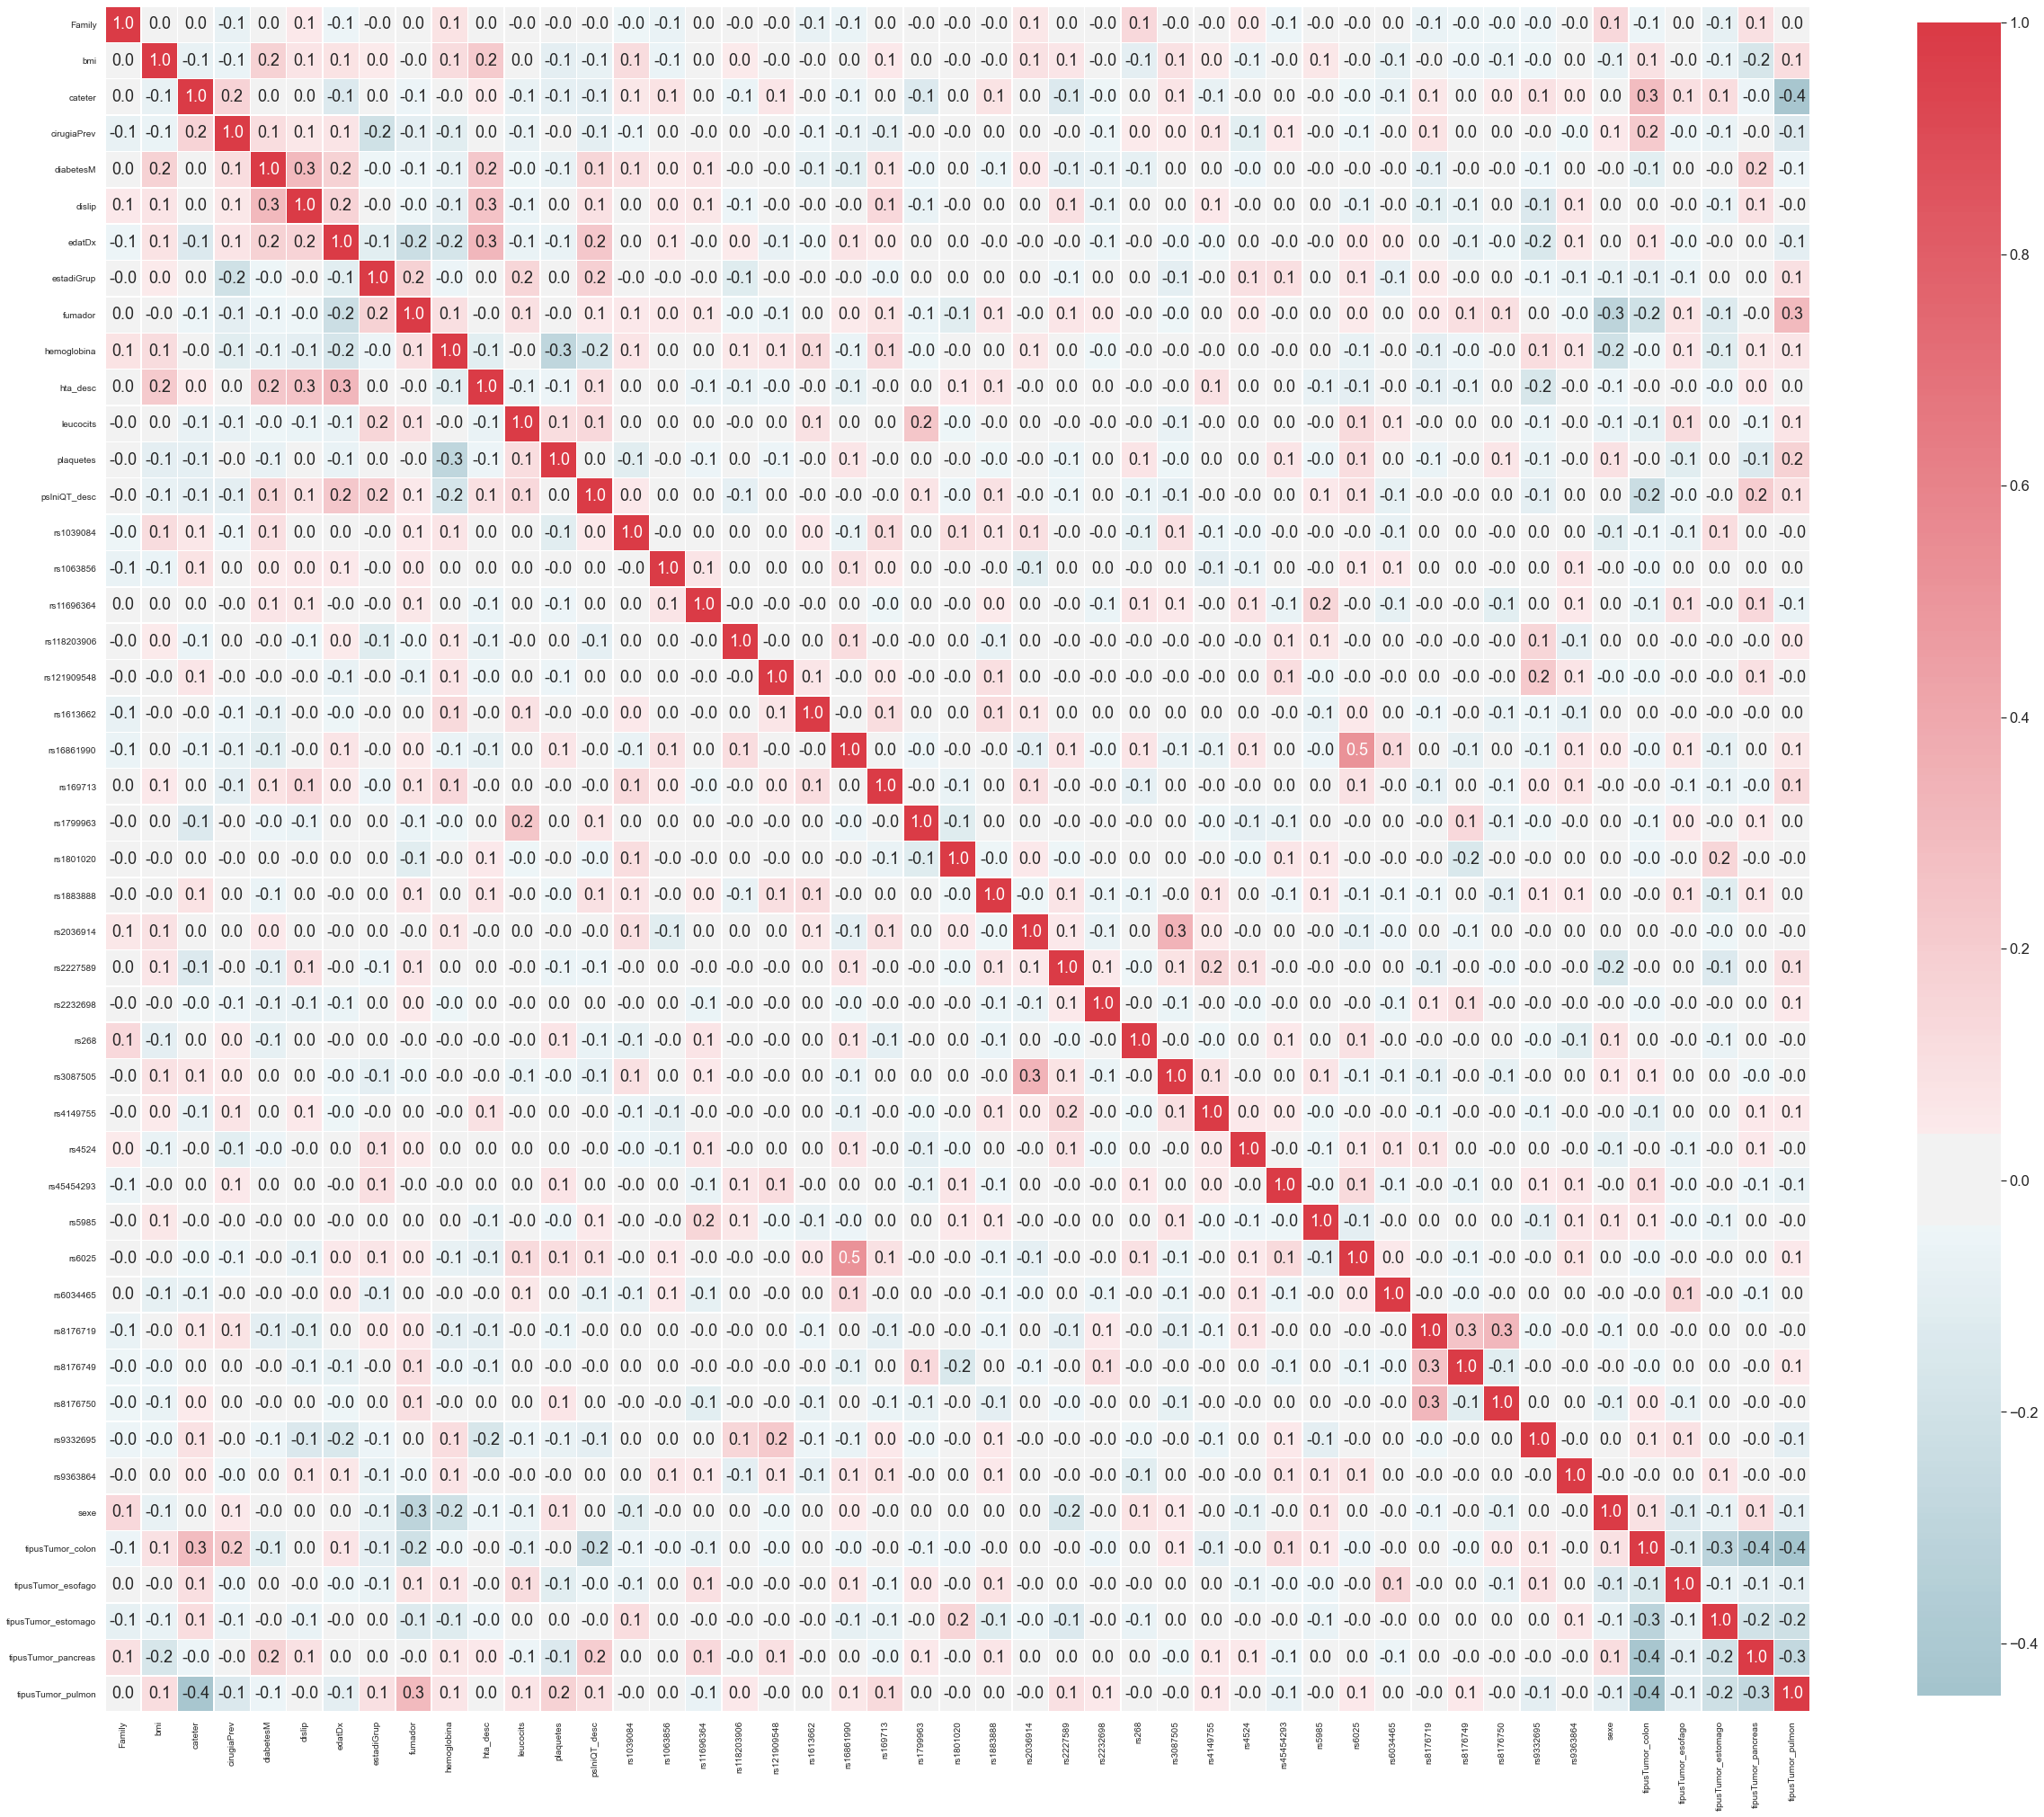

In [125]:
def heatmap(df):
    correlations = df.corr()
    ## Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    fig, ax = plt.subplots(figsize=(35, 35))
    fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.1f',square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 10)
    fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.tight_layout()
    plt.show()

heatmap(X)